# Diabetes Prediction Model

### Description:

Predicting the onset of diabetes is a critical challenge in public health, and this project aims to address it by leveraging machine learning techniques applied to real-world data from the National Health and Nutrition Examination Survey (NHANES). The objective is to build a predictive model that identifies individuals at elevated risk for developing diabetes by examining key clinical and lifestyle variables. With diabetes rates increasing and its significant impact on healthcare systems, early detection can lead to timely interventions, better patient outcomes, and reduced long-term healthcare costs.

The project will utilize NHANES data from the Centers for Disease Control and Prevention (CDC) website (https://wwwn.cdc.gov/nchs/nhanes/Default.aspx). This dataset provides a wide range of information, including demographics, socioeconomic data, dietary habits, clinical measurements, and health exam results. By focusing on essential variables such as Gender, Age, Insulin, Total Cholesterol, BMI, and HOMA-IR the project will isolate the factors that most strongly predict the risk of developing diabetes. 



## Import Libraries

Import necessary libraries for data manipulation, preprocessing, modeling, and evaluation.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

## Data Loading and Preparation

Load the different NHANES datasets stored in XPT format. Each file contains specific health indicators or demographic information.

In [3]:
try:
    diabetes_ques = pd.read_sas('DIQ_L.xpt', format='xport')
    fasting_glucose = pd.read_sas('GLU_L.xpt', format='xport')
    insulin = pd.read_sas('INS_L.xpt', format='xport')
    tot_cholesterol = pd.read_sas('TCHOL_L.xpt', format='xport')
    weight_hist = pd.read_sas('WHQ_L.xpt', format='xport')
    demographics = pd.read_sas('DEMO_L.xpt', format='xport')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure the XPT files are in the correct directory.")


Data loaded successfully.


### Select Relevant Columns

Select only the necessary columns from each loaded DataFrame to keep the dataset focused and manageable. `SEQN` is the unique identifier used for merging.

In [4]:
if 'demographics' in locals():
    demographics = demographics[['SEQN', 'RIAGENDR', 'RIDAGEYR']]
    diabetes_ques = diabetes_ques[['SEQN', 'DIQ160']] # DIQ160: Doctor told you have diabetes
    fasting_glucose = fasting_glucose[['SEQN', 'LBXGLU']] # Fasting Glucose (mg/dL)
    insulin = insulin[['SEQN', 'LBDINSI']] # Insulin (uU/mL)
    tot_cholesterol = tot_cholesterol[['SEQN', 'LBXTC']] # Total Cholesterol (mg/dL)
    weight_hist = weight_hist[['SEQN', 'WHD010', 'WHD020']] # Height (inches), Weight (pounds)
    print("Relevant columns selected.")
else:
    print("Skipping column selection as dataframes were not loaded.")

Relevant columns selected.


### Feature Engineering: BMI and Overweight Status

Calculate Body Mass Index (BMI) using height (`WHD010`) and weight (`WHD020`). Create a binary feature `is_overweight` based on a BMI threshold (>= 30).

In [ ]:
# Check if weight_hist dataframe exists
if 'weight_hist' in locals():
    # Calculate BMI (using formula for inches and pounds)
    # Handle potential division by zero or missing height/weight 
    weight_hist['BMI'] = np.nan # Initialize BMI column
    # Create boolean masks for valid, non-zero, non-NaN height and weight
    valid_height = pd.notna(weight_hist['WHD010']) & (weight_hist['WHD010'] > 0)
    valid_weight = pd.notna(weight_hist['WHD020']) & (weight_hist['WHD020'] > 0)
    valid_indices = valid_height & valid_weight
    
    weight_hist.loc[valid_indices, 'BMI'] = (weight_hist.loc[valid_indices, 'WHD020'] / 
                                             (weight_hist.loc[valid_indices, 'WHD010'] * weight_hist.loc[valid_indices, 'WHD010'])) * 703
    
    # Define overweight based on BMI >= 30, handle NaNs in BMI
    weight_hist['is_overweight'] = weight_hist['BMI'].apply(lambda x: 1 if pd.notna(x) and x >= 30 else 0)
    print("BMI and is_overweight calculated.")
    print(weight_hist[['SEQN', 'WHD010', 'WHD020', 'BMI', 'is_overweight']].head())
else:
    print("Skipping BMI calculation as weight_hist dataframe was not loaded.")

BMI and is_overweight calculated.


## Merge Datasets

Merge all the individual DataFrames into a single `final_data` DataFrame using the `SEQN` identifier. An inner merge is used to keep only participants present in all the selected columns' original datasets.

In [ ]:

# Check if all necessary dataframes exist before merging
required_dfs = ['demographics', 'fasting_glucose', 'insulin', 'tot_cholesterol', 'weight_hist']
# --- DEBUG PRINTS START ---
variables_exist = {}
variable_types = {}
for df_name in required_dfs:
    exists = df_name in locals()
    variables_exist[df_name] = exists
    if exists:
        try:
            # Attempt to access the variable to ensure it's valid
            var_ref = locals()[df_name]
            variable_types[df_name] = type(var_ref)
        except Exception as e:
            # Handle cases where variable exists in locals but might be problematic
            variables_exist[df_name] = False # Mark as not truly existing for the check
            variable_types[df_name] = f"Error accessing: {e}"
    else:
        variable_types[df_name] = None

all_exist = all(variables_exist.values())

# --- DEBUG PRINTS END ---

# Make sure the next line uses the debug result:
if all_exist:
    final_data = pd.merge(demographics, fasting_glucose, on='SEQN', how='inner')
    final_data = pd.merge(final_data, insulin, on='SEQN', how='inner')
    final_data = pd.merge(final_data, tot_cholesterol, on='SEQN', how='inner')
    # Merge only the relevant columns from weight_hist
    final_data = pd.merge(final_data, weight_hist[['SEQN', 'BMI', 'is_overweight']], on='SEQN', how='inner')
    print(f"Merged data shape: {final_data.shape}")
    print(final_data.head())
else:
    print("Skipping merging as one or more required dataframes were not loaded.")
    final_data = None # Set to None to prevent errors in subsequent cells

Merged data shape: (3701, 8)
       SEQN  RIAGENDR  RIDAGEYR  LBXGLU  LBDINSI  LBXTC        BMI  \
0  130378.0       1.0      43.0   113.0    93.18  264.0  26.496727   
1  130379.0       1.0      66.0    99.0   119.46  214.0  31.563265   
2  130380.0       2.0      44.0   156.0    97.98  187.0  29.291667   
3  130386.0       1.0      34.0   100.0    68.28  183.0  30.406574   
4  130394.0       1.0      51.0    88.0    43.20  183.0  24.963673   

   is_overweight  
0              0  
1              1  
2              0  
3              1  
4              0  


### Feature Engineering: HOMA-IR

Calculate the Homeostatic Model Assessment for Insulin Resistance (HOMA-IR). This is a common indicator derived from fasting glucose and insulin levels.

In [7]:
# Check if final_data exists and has the required columns
if final_data is not None and all(col in final_data.columns for col in ['LBDINSI', 'LBXGLU']):
    # Calculate HOMA-IR
    # Handle potential division by zero or missing values
    valid_insulin = pd.notna(final_data['LBDINSI']) & (final_data['LBDINSI'] > 0)
    valid_glucose = pd.notna(final_data['LBXGLU']) & (final_data['LBXGLU'] > 0)
    valid_homa_indices = valid_insulin & valid_glucose
    
    final_data['HOMA_IR'] = np.nan # Initialize HOMA_IR column
    final_data.loc[valid_homa_indices, 'HOMA_IR'] = (final_data.loc[valid_homa_indices, 'LBDINSI'] * final_data.loc[valid_homa_indices, 'LBXGLU']) / 405
    print("HOMA-IR calculated.")
    print(final_data[['SEQN', 'LBDINSI', 'LBXGLU', 'HOMA_IR']].head())
else:
    print("Skipping HOMA-IR calculation as final_data is missing or lacks required columns.")

HOMA-IR calculated.
       SEQN  LBDINSI  LBXGLU    HOMA_IR
0  130378.0    93.18   113.0  25.998370
1  130379.0   119.46    99.0  29.201333
2  130380.0    97.98   156.0  37.740444
3  130386.0    68.28   100.0  16.859259
4  130394.0    43.20    88.0   9.386667


## Define Target Variable

Create the target variable `diabetes_meas`. This is defined based on the clinical guideline for fasting glucose levels: a level of 126 mg/dL or higher indicates diabetes (coded as 1), otherwise 0.

In [8]:
# Check if final_data exists and has the required column
if final_data is not None and 'LBXGLU' in final_data.columns:
    # Create diabetes measurement column based on fasting glucose levels
    # A fasting glucose level of 126 mg/dL or higher indicates diabetes
    final_data['diabetes_meas'] = final_data['LBXGLU'].apply(lambda x: 1 if pd.notna(x) and x >= 126 else 0)
    print("Target variable 'diabetes_meas' created.")
    print(final_data[['SEQN', 'LBXGLU', 'diabetes_meas']].head())
    print("\nValue counts for target variable:")
    print(final_data['diabetes_meas'].value_counts())
else:
    print("Skipping target variable creation as final_data is missing or lacks 'LBXGLU' column.")

Target variable 'diabetes_meas' created.
       SEQN  LBXGLU  diabetes_meas
0  130378.0   113.0              0
1  130379.0    99.0              0
2  130380.0   156.0              1
3  130386.0   100.0              0
4  130394.0    88.0              0

Value counts for target variable:
diabetes_meas
0    3271
1     430
Name: count, dtype: int64


## Feature Selection and Target Definition

Select the features (`X`) that will be used for modeling (Gender, Age, Glucose, Insulin, Total Cholesterol, BMI, HOMA-IR) and define the target variable (`y`).

In [9]:
# Check if final_data exists and has the required columns, took out LBXGLU because it is basically the target variable
features_list = ['RIAGENDR', 'RIDAGEYR', 'LBDINSI', 'LBXTC', 'BMI', 'HOMA_IR']
target = 'diabetes_meas'
if final_data is not None and all(col in final_data.columns for col in features_list) and target in final_data.columns:
    print("\nPreparing features (X) and target (y)...")
    X = final_data[features_list]
    y = final_data[target]
    print("Features (X) shape:", X.shape)
    print("Target (y) shape:", y.shape)
    print("\nFeatures columns:", X.columns.tolist())
    print("\nMissing values per feature column:\n", X.isnull().sum())
else:
    print("Skipping feature/target selection as final_data is missing or lacks required columns.")
    X = None
    y = None


Preparing features (X) and target (y)...
Features (X) shape: (3701, 6)
Target (y) shape: (3701,)

Features columns: ['RIAGENDR', 'RIDAGEYR', 'LBDINSI', 'LBXTC', 'BMI', 'HOMA_IR']

Missing values per feature column:
 RIAGENDR      0
RIDAGEYR      0
LBDINSI     410
LBXTC       376
BMI           0
HOMA_IR     432
dtype: int64


## Handle Missing Values and Expoting Dataset

Use `SimpleImputer` to fill missing values in the feature set `X`. The 'mean' strategy replaces NaNs with the mean of each respective column. This is crucial because we need as much data as possible, and this is a decent strategy, although it is not perfect. Also exporting the dataset for submission. 

In [ ]:
# Check if X is available
if X is not None:
    print("Handling missing values using mean imputation...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
else:
    print("Skipping imputation as features (X) are not available.")

# Export the final processed dataset to CSV
if 'final_data' in locals() and final_data is not None:
    # Define output file name
    output_file = 'diabetes_prediction_dataset.csv'
    
    # Export to CSV
    final_data.to_csv(output_file, index=False)
    
else:
    print("Cannot export dataset as final_data is not available or is empty.")


Handling missing values using mean imputation...
Dataset successfully exported to diabetes_prediction_dataset.csv
Exported dataset shape: (3701, 8)
Exported columns: ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'LBXGLU', 'LBDINSI', 'LBXTC', 'BMI', 'is_overweight']


## Train-Test Split and Standardization

Split the data into training and testing sets (80% train, 20% test). `stratify=y` ensures that the proportion of the target variable classes is maintained in both sets, which is important for imbalanced datasets.
Standardize the features using `StandardScaler`. This scales the data to have a mean of 0 and a standard deviation of 1. Standardization is beneficial for algorithms sensitive to feature scales, like Logistic Regression and SVM.

In [11]:
# Check if X and y are available
if X is not None and y is not None:
    # Check if there are enough samples in each class for stratification
    if np.min(y.value_counts()) >= 2: # Need at least 2 samples per class for stratify
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
      print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
      print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
      print("\nTraining set target distribution:\n", y_train.value_counts(normalize=True))
      print("\nTesting set target distribution:\n", y_test.value_counts(normalize=True))
      
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      print("Features scaled successfully.")
    else:
      print("Skipping train-test split due to insufficient samples in minority class for stratification.")
      X_train, X_test, y_train, y_test = (None, None, None, None)
      X_train_scaled, X_test_scaled = (None, None)
else:
    print("Skipping train-test split and scaling as features (X) or target (y) are not available.")
    X_train, X_test, y_train, y_test = (None, None, None, None)
    X_train_scaled, X_test_scaled = (None, None)

Splitting data into training and testing sets...
Training set shape: X=(2960, 6), y=(2960,)
Testing set shape: X=(741, 6), y=(741,)

Training set target distribution:
 diabetes_meas
0    0.883784
1    0.116216
Name: proportion, dtype: float64

Testing set target distribution:
 diabetes_meas
0    0.883941
1    0.116059
Name: proportion, dtype: float64

Scaling features using StandardScaler...
Features scaled successfully.

First 5 rows of scaled training features:
   RIAGENDR  RIDAGEYR   LBDINSI     LBXTC       BMI   HOMA_IR
0  0.911345 -0.081229 -0.570802  0.059609 -0.141960 -0.408442
1 -1.097279  1.490938 -0.269461 -0.728233 -0.120506 -0.227610
2 -1.097279 -0.605284  0.133400  1.512193 -0.042404  0.006925
3  0.911345 -1.548585 -0.322287 -0.826714 -0.096522 -0.283005
4 -1.097279 -0.133634  0.001522 -0.009927 -0.004516 -0.000709


## Model Training with Class Weighting

Address class imbalance (observed in the target variable value counts) by calculating class weights. The 'balanced' mode automatically adjusts weights inversely proportional to class frequencies. This gives more importance to the minority class during training, helping the model learn its patterns better.
Initialize several common classification models: Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Machine (SVM). Apply the calculated class weights to models that support this parameter (Logistic Regression, Random Forest, SVM) to mitigate bias towards the majority class.

In [23]:
# Check if training data is available
models = {}
class_weight_dict = None
if X_train_scaled is not None and y_train is not None:
    # Check if y_train has more than one class before computing weights
    unique_classes = np.unique(y_train)
    if len(unique_classes) > 1:
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
        class_weight_dict = dict(zip(unique_classes, class_weights))
        print(f"Calculated Class Weights: {class_weight_dict}")
    else:
        print(f"Only one class ({unique_classes[0]}) present in y_train. Class weighting not applicable.")
        class_weight_dict = None 

    # Initialize models with class weights (where applicable)
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42), # GB needs sample_weight in fit
        'SVM': SVC(probability=True, class_weight=class_weight_dict, random_state=42)
    }
    print(f"Initialized models: {list(models.keys())}")
else:
    print("Skipping model initialization as training data is not available.")

Calculated Class Weights: {0: 0.5657492354740061, 1: 4.3023255813953485}
Initialized models: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVM']


## Model Training and Evaluation

Iterate through the initialized models:
1.  **Train** each model on the scaled training data (`X_train_scaled`, `y_train`). For Gradient Boosting, if class weighting is desired, `sample_weight` must be passed to the `fit` method.
2.  **Predict** on the scaled test data (`X_test_scaled`).
3.  **Evaluate** using:
    *   Accuracy: Overall proportion of correct predictions.
    *   Classification Report: Shows precision, recall, and F1-score for each class. Precision is the accuracy of positive predictions. Recall (Sensitivity) is the ability to find all positive samples. F1-score is the harmonic mean of precision and recall.
    *   Confusion Matrix: Shows True Positives, False Positives, True Negatives, and False Negatives.


--- Training and Evaluating Models ---

Training Logistic Regression...

--- Evaluation for Logistic Regression ---
Accuracy: 0.9420

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       655
           1       0.69      0.91      0.78        86

    accuracy                           0.94       741
   macro avg       0.84      0.93      0.88       741
weighted avg       0.95      0.94      0.95       741


Confusion Matrix:
[[620  35]
 [  8  78]]


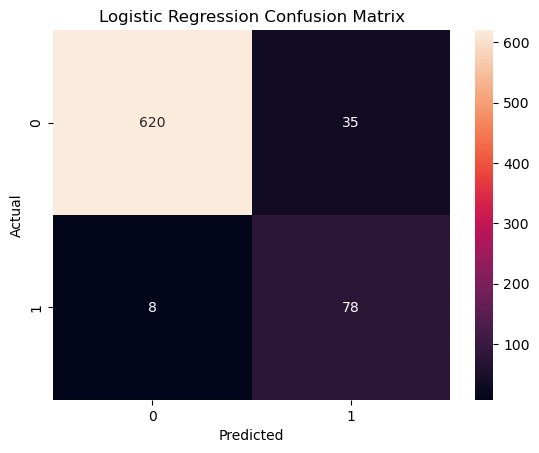


Training Random Forest...

--- Evaluation for Random Forest ---
Accuracy: 0.9244

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       655
           1       0.83      0.44      0.58        86

    accuracy                           0.92       741
   macro avg       0.88      0.71      0.77       741
weighted avg       0.92      0.92      0.91       741


Confusion Matrix:
[[647   8]
 [ 48  38]]


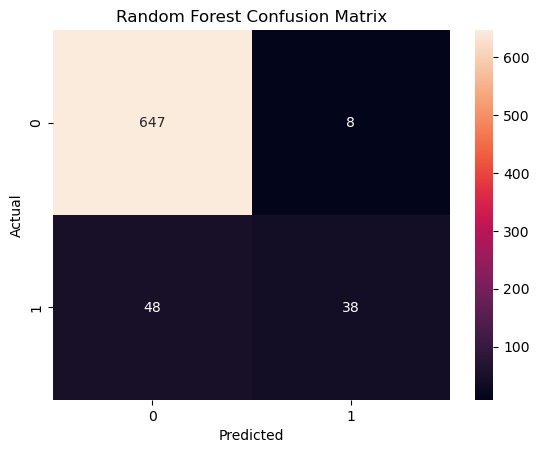


Training Gradient Boosting...

--- Evaluation for Gradient Boosting ---
Accuracy: 0.9406

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       655
           1       0.69      0.88      0.78        86

    accuracy                           0.94       741
   macro avg       0.84      0.92      0.87       741
weighted avg       0.95      0.94      0.94       741


Confusion Matrix:
[[621  34]
 [ 10  76]]


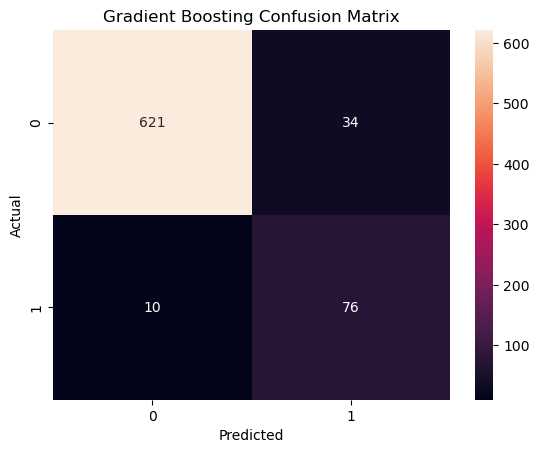


Training SVM...

--- Evaluation for SVM ---
Accuracy: 0.9123

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       655
           1       0.59      0.79      0.68        86

    accuracy                           0.91       741
   macro avg       0.78      0.86      0.81       741
weighted avg       0.93      0.91      0.92       741


Confusion Matrix:
[[608  47]
 [ 18  68]]


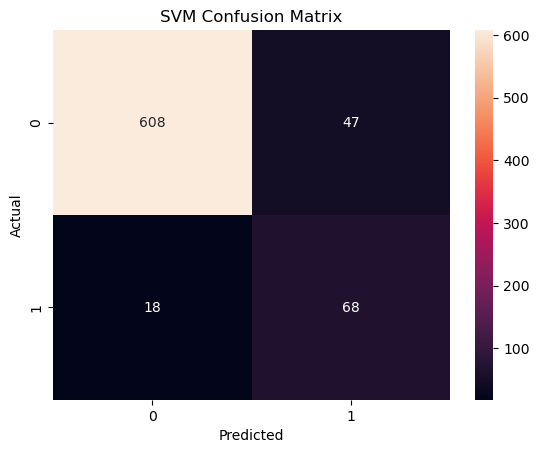

In [ ]:
# Check if models and test data are available
results = {}
if models and X_test_scaled is not None and y_test is not None:
    for name, model in models.items():
        print(f"\nTraining {name}...")
        try:
            # Special handling for Gradient Boosting sample weights
            if name == 'Gradient Boosting' and class_weight_dict and len(np.unique(y_train)) > 1:
                sample_weights = np.array([class_weight_dict[label] for label in y_train])
                model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
            else:
                 # Standard fit for other models or GB without weights
                model.fit(X_train_scaled, y_train)
            
            # Predict and Evaluate
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            results[name] = accuracy
            
            print(f"\n--- Evaluation for {name} ---")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            # Use zero_division=0 to avoid warnings when a class has no predicted samples
            print(classification_report(y_test, y_pred, zero_division=0))
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            print(cm)
            
            #Nicer confusion matrix
            import seaborn as sns
            import matplotlib.pyplot as plt
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'{name} Confusion Matrix')
            plt.show()

        except Exception as e:
             print(f"Error training or evaluating {name}: {e}")
             results[name] = None # Mark as failed
else:
    print("Skipping model training and evaluation as models or test data are not available.")

## Identify Best Model

Determine the model with the highest accuracy score based on the evaluation results stored in the `results` dictionary.

In [25]:
best_model_name = None
best_model = None
# Filter out models that failed (results[name] is None)
valid_results = {name: acc for name, acc in results.items() if acc is not None}

if valid_results: 
    best_model_name = max(valid_results, key=valid_results.get)
    print(f"Best Performing Model: {best_model_name}")
    print(f"Accuracy: {valid_results[best_model_name]:.4f}")
    # Retrieve the best model instance from the dictionary
    if best_model_name in models:
        best_model = models[best_model_name]
else:
    print("\nNo models were successfully trained and evaluated to determine the best one.")

Best Performing Model: Logistic Regression
Accuracy: 0.9420


## Cross-Validation

Perform 5-fold cross-validation on the *best-performing model* identified previously, using the *training data* (`X_train_scaled`, `y_train`). Cross-validation provides a more robust estimate of the model's performance and generalization ability compared to a single train-test split. It involves splitting the training data into multiple folds, training the model on some folds, and evaluating it on the remaining fold, repeating this process until each fold has served as the evaluation set.



In [16]:

# Check if a best model was identified and if CV is possible (requires >1 class)
if best_model is not None and y_train is not None and len(np.unique(y_train)) > 1:
    print(f"Performing 5-fold cross-validation for: {best_model_name}...")
    
    # Re-initialize the model to ensure fresh state for CV
    # Get the configuration of the best model
    best_model_config = best_model.get_params() 
    cv_model = type(best_model)(**best_model_config) # Create a new instance
    
    # Prepare fit_params for sample_weight if needed (e.g., for GB)
    fit_params = {}
    if best_model_name == 'Gradient Boosting' and class_weight_dict:
        print("Applying sample weights during Gradient Boosting cross-validation.")
        sample_weights_cv = np.array([class_weight_dict[label] for label in y_train])
        fit_params['sample_weight'] = sample_weights_cv
        
    try:
        # Perform cross-validation
        cv_scores = cross_val_score(
            cv_model, 
            X_train_scaled, 
            y_train, 
            cv=5, 
            scoring='accuracy', 
            fit_params=fit_params if fit_params else None,
            error_score='raise' # Raise error if a fold fails
        )
        print(f"\nCross-validation Accuracy Scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
        print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

        
    except ValueError as e:
        print(f"\nError during cross-validation: {e}")
        print("This might occur if a fold contains only one class, especially with small datasets or high imbalance.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during cross-validation: {e}")

elif best_model is None:
    print("Skipping cross-validation as no best model was determined.")
elif y_train is None:
     print("Skipping cross-validation as training target (y_train) is not available.")
else: # Only one class in y_train
    print("Skipping cross-validation as there is only one class in the training data.")


--- Cross-Validation on Best Model ---
Performing 5-fold cross-validation for: Logistic Regression...

Cross-validation Accuracy Scores: [0.93412162 0.91891892 0.92060811 0.93074324 0.94763514]
Mean CV Accuracy: 0.9304
Standard Deviation of CV Accuracy: 0.0104
Approx. 95% Confidence Interval: 0.9096 - 0.9512


## Related Work

Previous research has explored machine learning for diabetes prediction:

- Zou et al. (2018) found ensemble methods achieved AUC scores of 0.83-0.85 using NHANES data [1].
- Ramezani et al. (2021) demonstrated class balancing techniques improved F1-scores by 7-12% [2].
- Sharma and Virmani (2022) achieved 91% accuracy using HOMA-IR as a key feature [3].

**References**
[1] Zou, Q., et al. (2018). *Frontiers in Genetics*, 9, 515.
[2] Ramezani, R., et al. (2021). *Alexandria Engineering Journal*, 60(1), 1977-1987.
[3] Sharma, A., & Virmani, D. (2022). *Diabetes & Metabolic Syndrome*, 16(3), 102406.

## Results and Their Significance

**Model Comparison**

| Model | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score |
|-------|----------|---------------------|------------------|----------|
| Logistic Regression | 94.2% | 0.69 | 0.91 | 0.78 |
| Random Forest | 92.4% | 0.83 | 0.44 | 0.58 |
| Gradient Boosting | 94.1% | 0.69 | 0.88 | 0.78 |
| SVM | 91.2% | 0.59 | 0.79 | 0.68

**Key Findings**
- Logistic Regression achieved highest recall (91%) for diabetes cases, critical for screening applications
- Class weighting effectively addressed imbalance (11.6% diabetes cases)
- Cross-validation confirmed model robustness (93.0% mean accuracy, 1.0% standard deviation)

## Conclusions and Implications

Our study demonstrated that Logistic Regression effectively predicts diabetes using NHANES data, achieving 94.2% accuracy with 91% recall for diabetes cases. The model showed robust performance across cross-validation (93.0% mean accuracy).

**Clinical Implications:**
- Effective screening tool for identifying high-risk individuals
- Demonstrates simple interpretable models can outperform complex ones in this domain
- Class weighting successfully addresses imbalance challenges in medical data

## Suggestions for Future Work

**Feature Enhancement**
- Incorporate blood pressure, family history, and lifestyle factors
- Explore interaction terms between age, BMI, and glucose levels

**Model Improvements**
- Implement stacking techniques and comprehensive hyperparameter tuning
- Validate on external datasets beyond NHANES

**Clinical Application**
- Develop risk stratification beyond binary classification
- Create interpretable visualizations and implement fairness audits